In [69]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from matplotlib.colors import ListedColormap

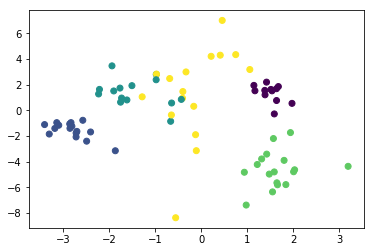

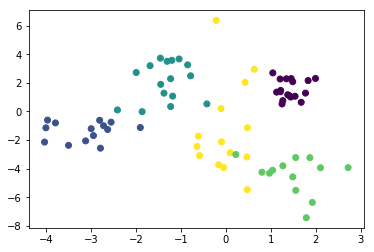

In [105]:
input_features = 2
mus_1 = np.array([1, -2, -1, 1, 0])*1.5
mus_2 = np.array([1, -1, 1, -3, 0])*1.5
vars_1 = np.array([1, 2, 2, 2, 2])/4
vars_2 = np.array([1, 1, 2, 2, 5])/1.5
N = 30
X = np.array([]).reshape(0,input_features)
y = np.array([]).reshape(0, 1)
for i in range(len(mus_1)):
    G1 = np.random.normal(mus_1[i], vars_1[i], N)
    G2 = np.random.normal(mus_2[i], vars_2[i], N)
    X_cat = np.vstack([G1,G2]).T
    X = np.vstack([X,X_cat])
    y_cat = np.ones(N).reshape(N,1)*i
    y = np.vstack([y,y_cat])
y = y.reshape(N*len(mus_1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.show()
plt.scatter(X_test[:,0], X_test[:,1], c=y_test)
plt.show()

In [157]:
#np.save('X_train_5_clases', X_train)
#np.save('X_test_5_clases', X_test)
#np.save('y_train_5_clases', y_train)
#np.save('y_test_5_clases', y_test)

In [106]:
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Activation
from helper import PlotLosses
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from keras import regularizers

In [143]:
lambd = 0 # 0.01
hidden_units = 20
output_size = len(mus_1)
model = Sequential()
model.add(Dense(hidden_units,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd)))
model.add(Activation('sigmoid'))
model.add(Dense(output_size))
model.add(Activation('softmax'))
model.summary()

lr = 0.04 
batch_size = 20
epochs = 1000

#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr)

# Lo compilo
model.compile(loss = 'categorical_crossentropy', optimizer=selectedOptimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 20)                60        
_________________________________________________________________
activation_27 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 105       
_________________________________________________________________
activation_28 (Activation)   (None, 5)                 0         
Total params: 165
Trainable params: 165
Non-trainable params: 0
_________________________________________________________________


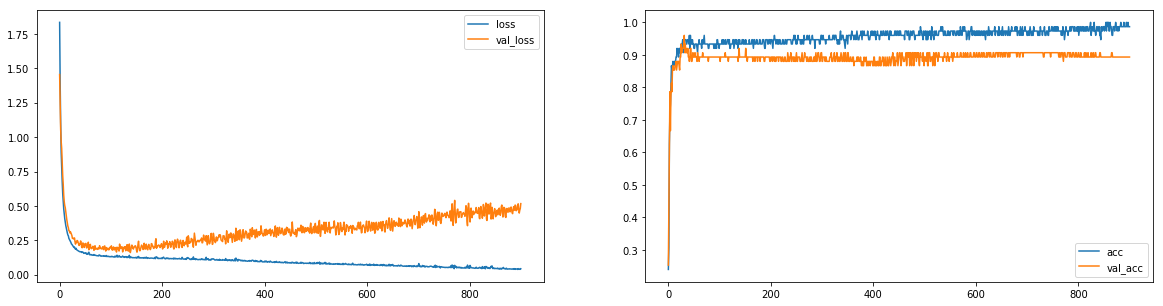

In [144]:
# Se puede tocar plot_interval para acelerar el proceso, el resto recomendamos no tocarlo
import shutil
import os
directory = './checkpoints_softmax/'

if os.path.exists(directory):
    shutil.rmtree(directory)
    os.mkdir(directory)
else:
    os.mkdir(directory)
    
checkpointer = ModelCheckpoint(filepath=directory+'weights.{epoch:04d}-{acc:.2f}.hdf5', period=1)
plot_losses = PlotLosses(plot_interval=100, 
                         evaluate_interval=None, 
                         x_val=X_test, 
                         y_val_categorical=y_test_cat)
model.fit(X_train, 
          y_train_cat, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=0, 
          validation_data=(X_test, y_test_cat), 
          callbacks=[plot_losses, checkpointer],
         )

In [145]:
def get_custom_cmap(Ri=0, Gi=0, Bi=0, alpha=0.8):
    N_c = 256
    R = np.hstack([np.zeros(int(N_c/2)), np.linspace(1, Ri, 128)])
    G = np.hstack([np.zeros(int(N_c/2)), np.linspace(1, Gi, 128)])
    B = np.hstack([np.zeros(int(N_c/2)), np.linspace(1, Bi, 128)])
    A = np.hstack([np.zeros(int(N_c/2)), alpha*np.ones(int(N_c/2))])
    custom_map = ListedColormap(np.vstack([R,G,B,A]).T)
    return custom_map

44832/46176 [============================>.] - ETA: 0s

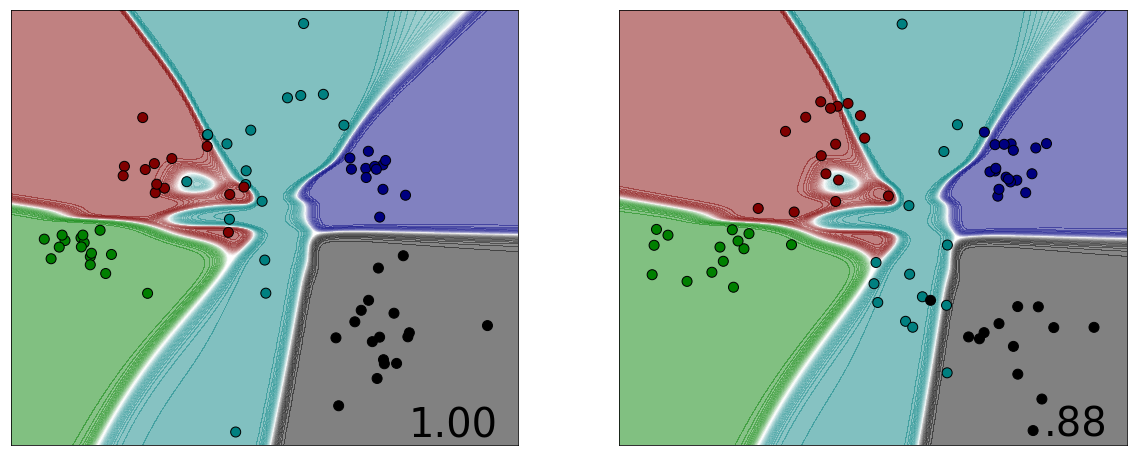

In [146]:
def plot_boundaries_keras(X_train, y_train, score, probability_func, degree=None, bias=False, h = .02, ax = None, margin=0.5):
    y_train_cat = to_categorical(y_train)
    X = X_train
    x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
    y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    if ax is None:
        ax = plt.subplot(1, 1, 1)
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    
    if degree is not None:
        polynomial_set = get_polynimial_set(np.c_[xx.ravel(), yy.ravel()], degree = degree, bias=bias)
        Zaux = probability_func(polynomial_set)
    else:
        Zaux = probability_func(np.c_[xx.ravel(), yy.ravel()])
        # Z = Z_aux[:, 1]
    
    # if Zaux.shape[1] == 2:
        # Es un polinomio
        # Z = Zaux[:, 1]
    # else:
        # No es un polinomio
        # Z = Zaux[:, 2]

    # Put the result into a color plot
    Z_reshaped = Zaux.reshape(xx.shape[0], xx.shape[1], y_train_cat.shape[1])
    
    cm_borders = ListedColormap(["#FFFFFFFF", "#000000"])
    my_colors = [[0,0,0.5], [0,0.5,0], [0.5,0,0], [0,0,0], [0,0.5,0.5]]
    for i in range(Z_reshaped.shape[2]):
        my_cmap = get_custom_cmap(my_colors[i][0],my_colors[i][1],my_colors[i][2], 0.5)
        Z = Z_reshaped[:,:,i]    
        
        cf = ax.contourf(xx, yy, 
                         #Z*(Z>0.5) + (Z<0.5)*0.5, 
                         Z,
                         50, 
                         vmin = 0,
                         vmax = 1,
                         cmap=my_cmap, 
                         #alpha=.9
                        )
        
    ax.scatter(X_train[:, 0], X_train[:, 1], 
               c=y_train, 
               cmap=ListedColormap(my_colors),
               edgecolors='k', 
               s=100)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=40, horizontalalignment='right')
    return Zaux, Z
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = model.evaluate(X_train, y_train_cat)
score_test = model.evaluate(X_test, y_test_cat)
Z_aux, Z = plot_boundaries_keras(X_train, y_train, score_train[1], model.predict_proba, h =.05, ax=ax1)
Z_aux, Z = plot_boundaries_keras(X_test, y_test, score_test[1], model.predict_proba, h =.05, ax=ax2)
plt.show()

In [147]:
import glob
files = []
for filename in glob.glob(directory+'*.hdf5'):
    files.append(filename)
files = np.sort(files)
N = files.shape[0]
N

1000

In [148]:
from helper import gen_log_space

In [149]:
directory_images = './images_softmax/'

if os.path.exists(directory_images):
    shutil.rmtree(directory_images)
    os.mkdir(directory_images)
else:
    os.mkdir(directory_images)

0
43392/46176 [===========================>..] - ETA: 0s

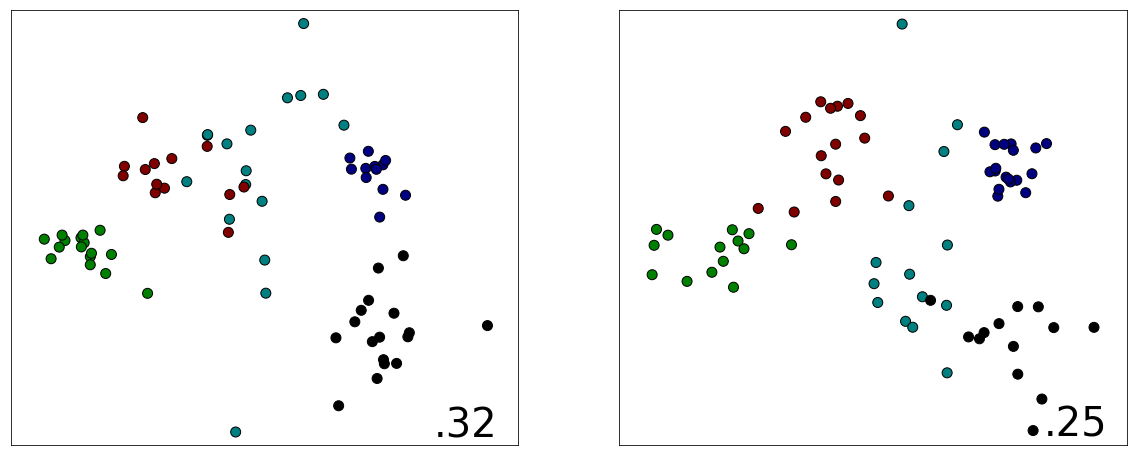

1
43744/46176 [===========================>..] - ETA: 0s

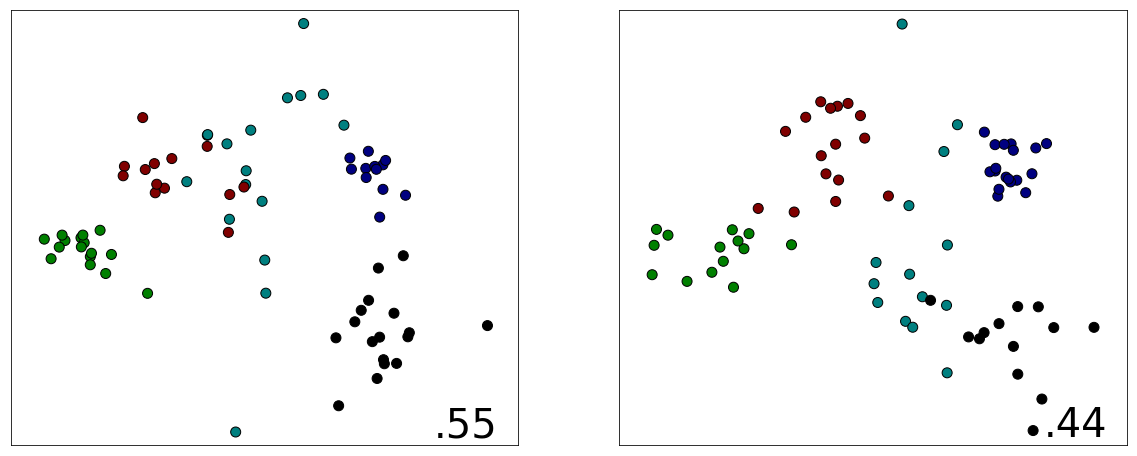

2
45856/46176 [============================>.] - ETA: 0s

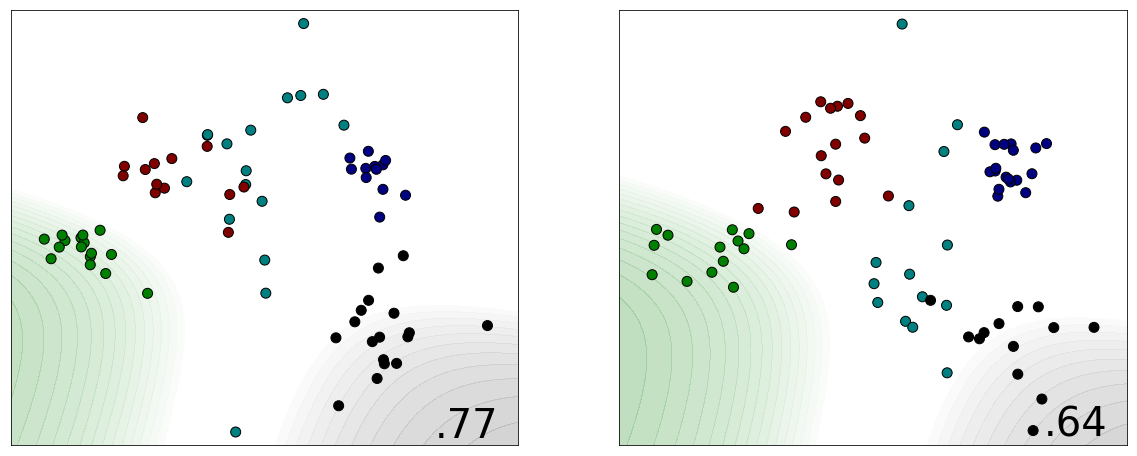

3
44160/46176 [===========================>..] - ETA: 0s

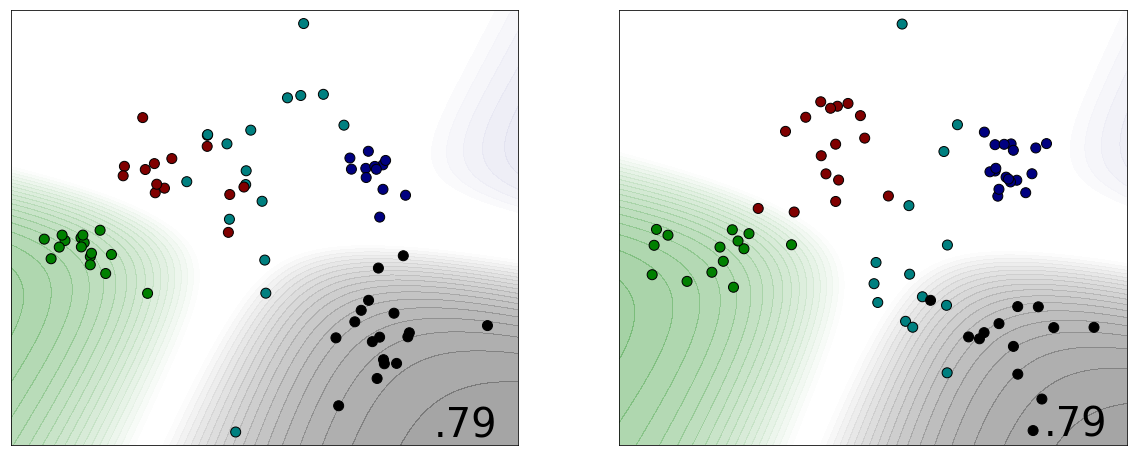

4
44832/46176 [============================>.] - ETA: 0s

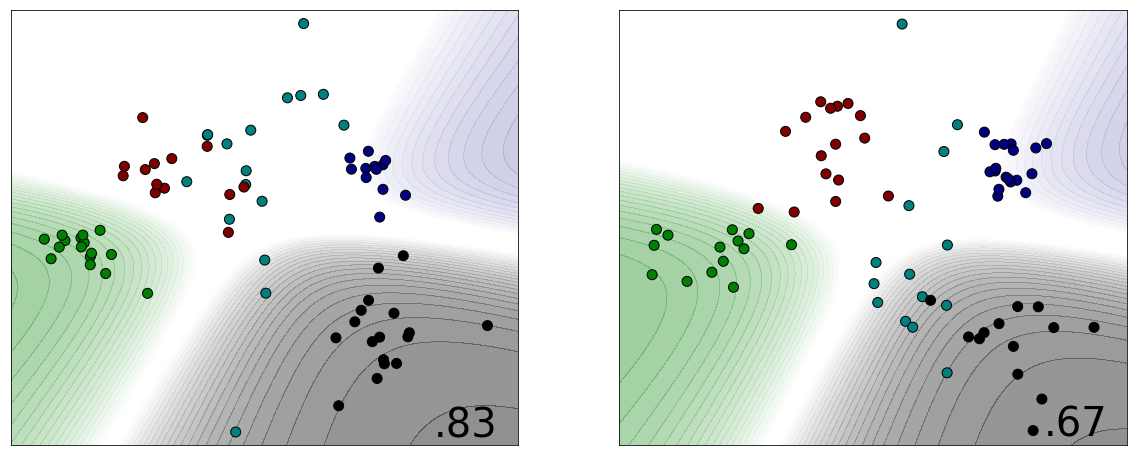

5
44640/46176 [============================>.] - ETA: 0s

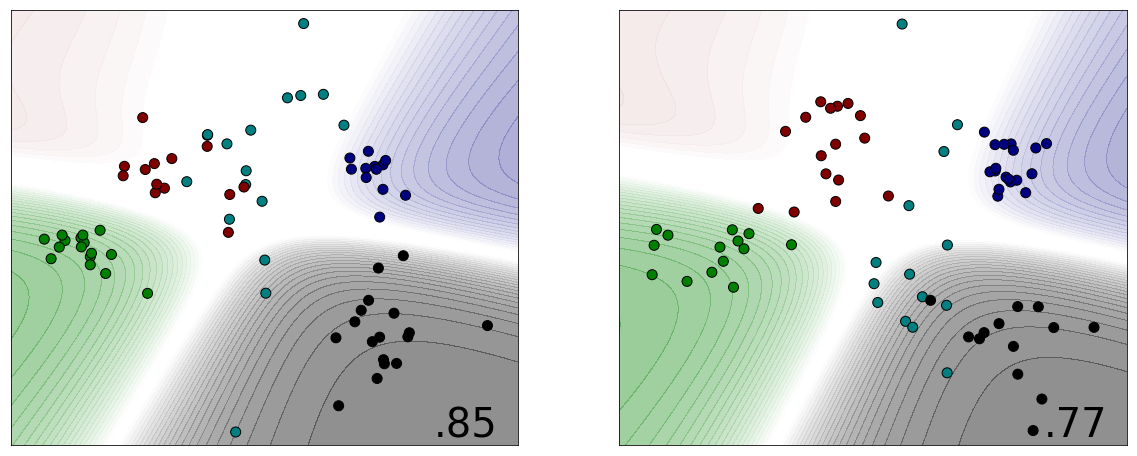

7
45952/46176 [============================>.] - ETA: 0s

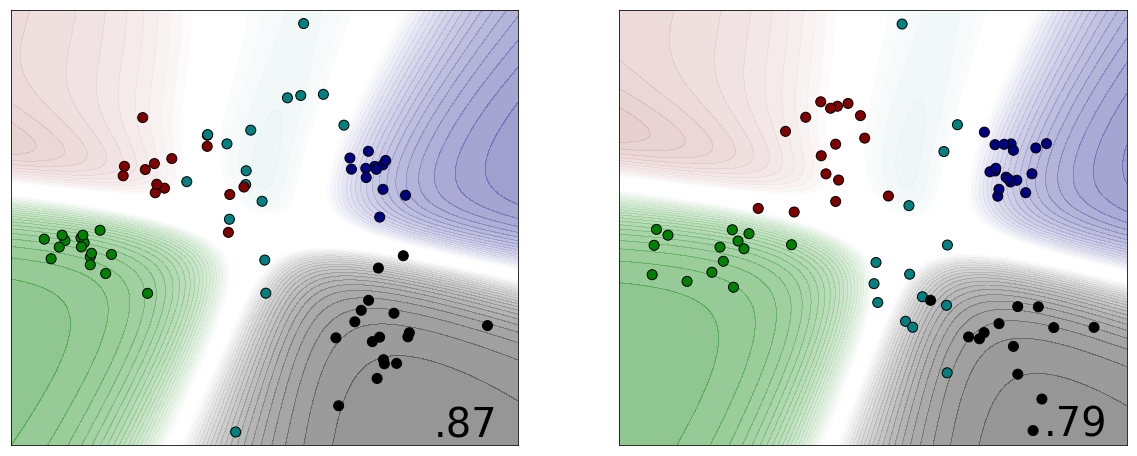

8
44512/46176 [===========================>..] - ETA: 0s

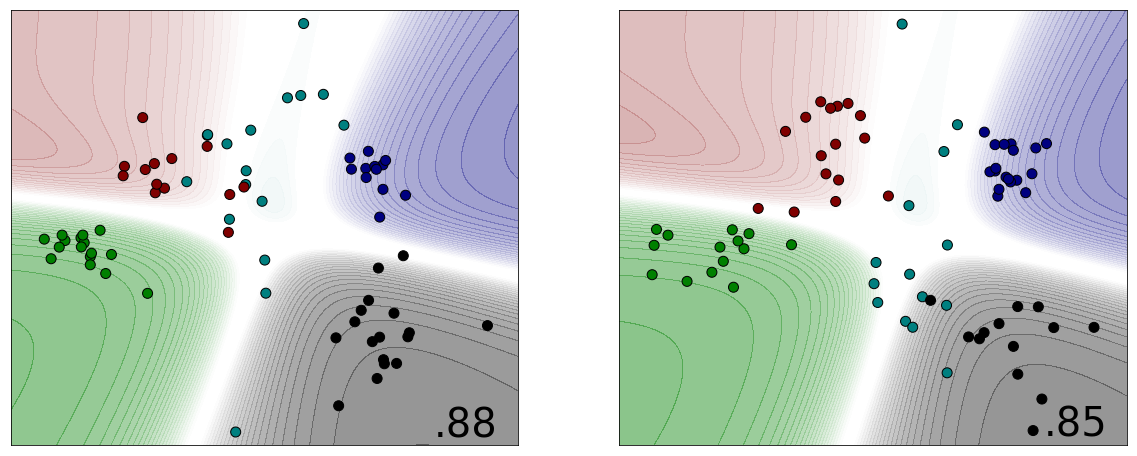

11
44416/46176 [===========================>..] - ETA: 0s

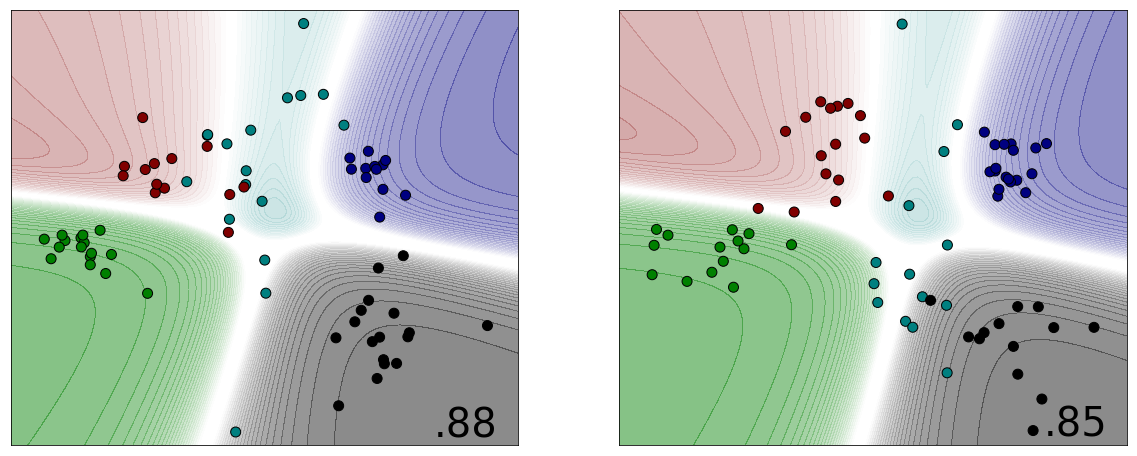

13
45600/46176 [============================>.] - ETA: 0s

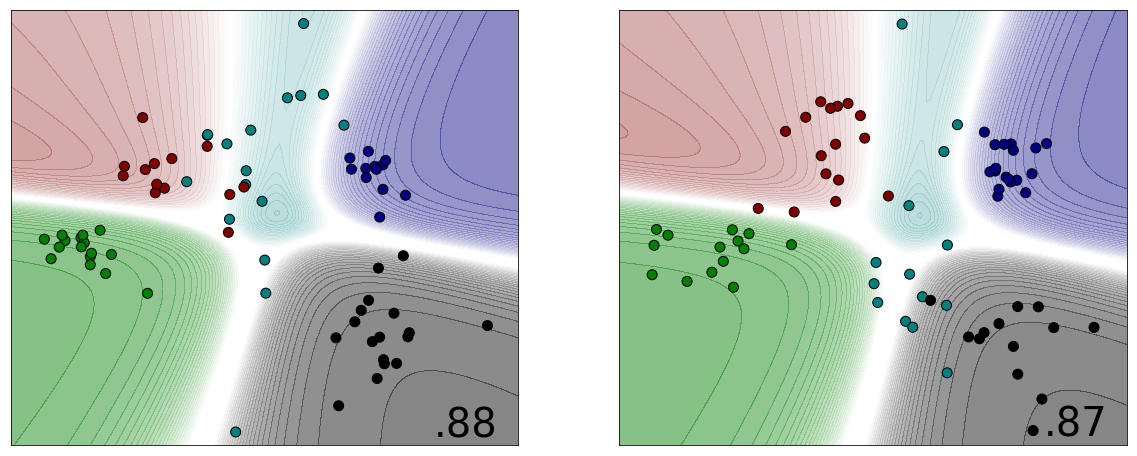

17
45792/46176 [============================>.] - ETA: 0s

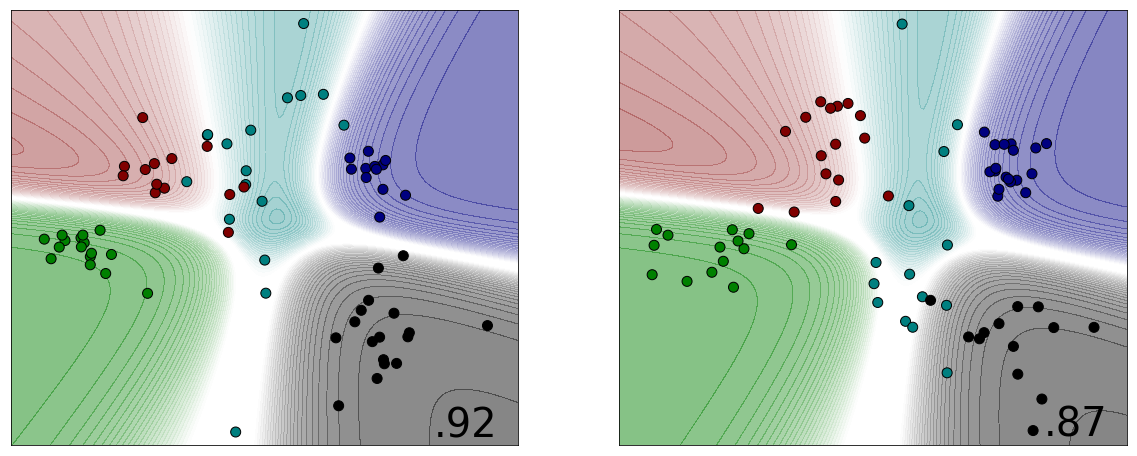

21
45952/46176 [============================>.] - ETA: 0s

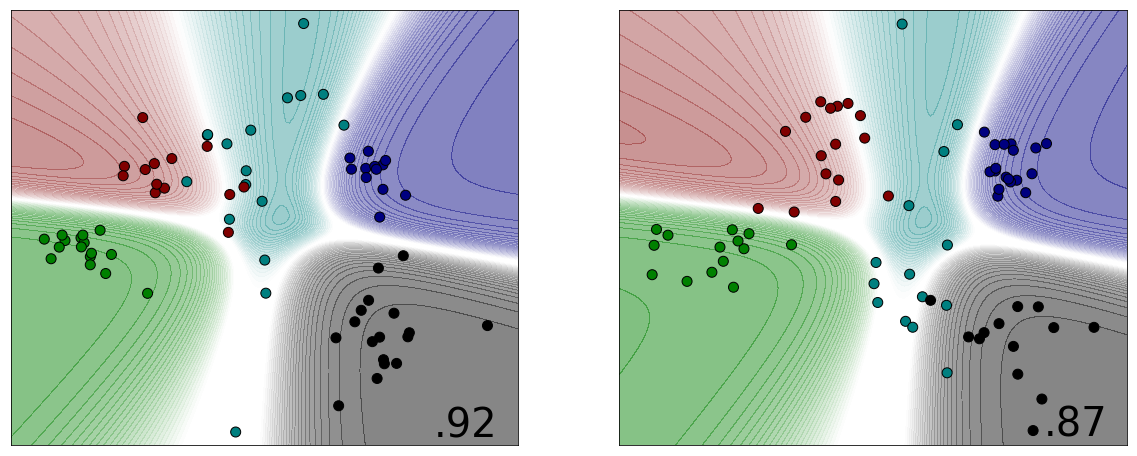

26
45152/46176 [============================>.] - ETA: 0s

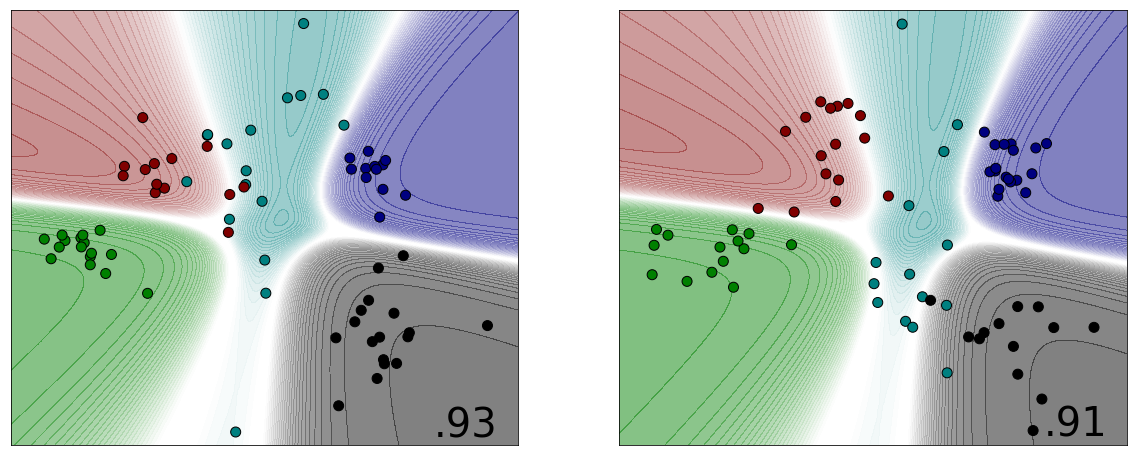

33
46112/46176 [============================>.] - ETA: 0s

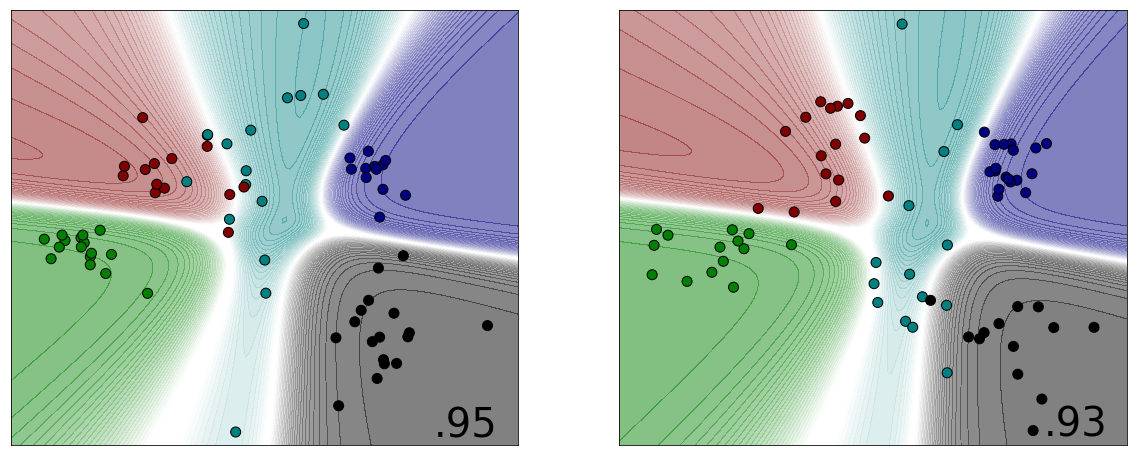

41
45504/46176 [============================>.] - ETA: 0s

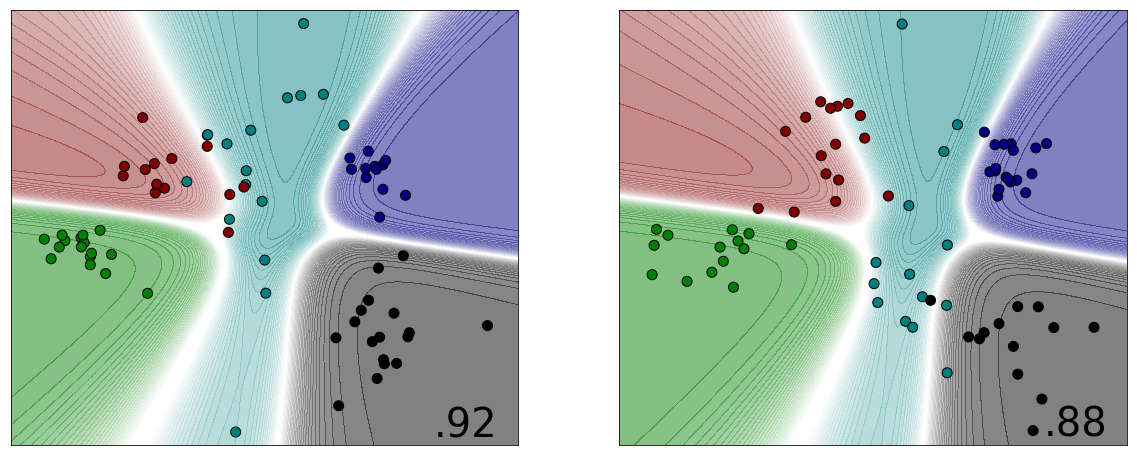

50
43808/46176 [===========================>..] - ETA: 0s

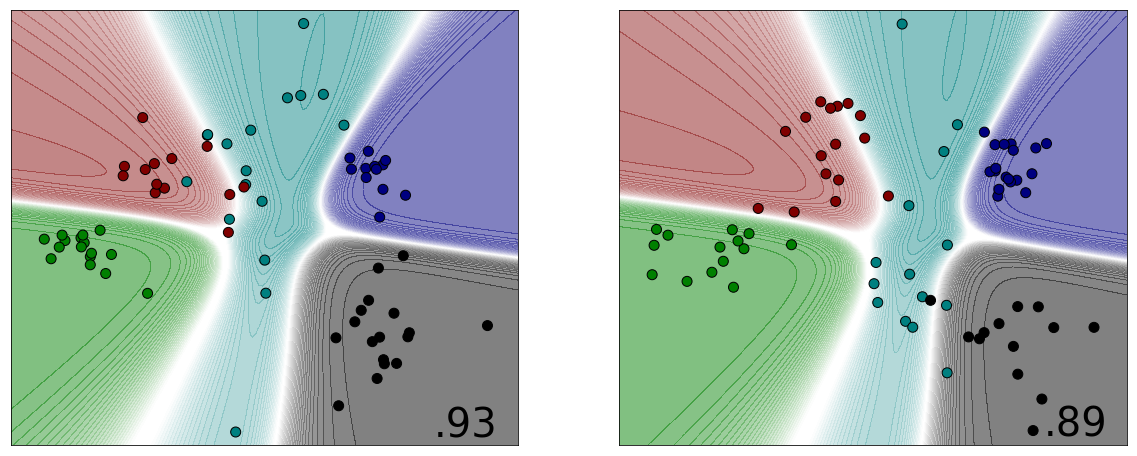

63
45440/46176 [============================>.] - ETA: 0s

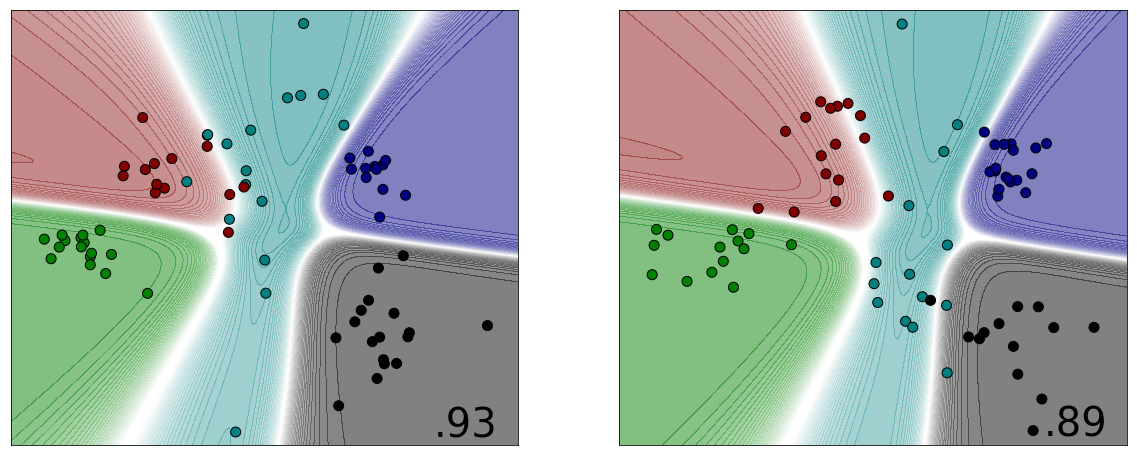

78
43744/46176 [===========================>..] - ETA: 0s

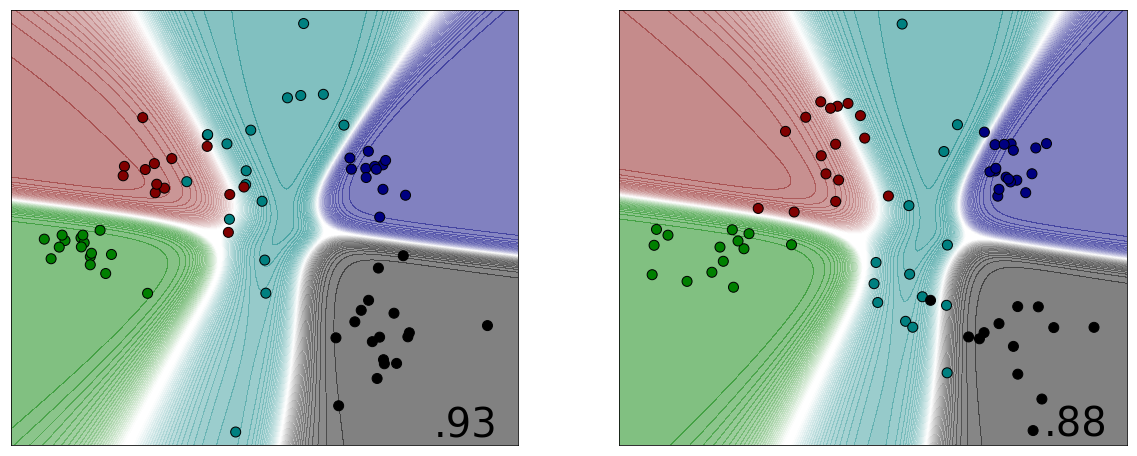

96
44512/46176 [===========================>..] - ETA: 0s

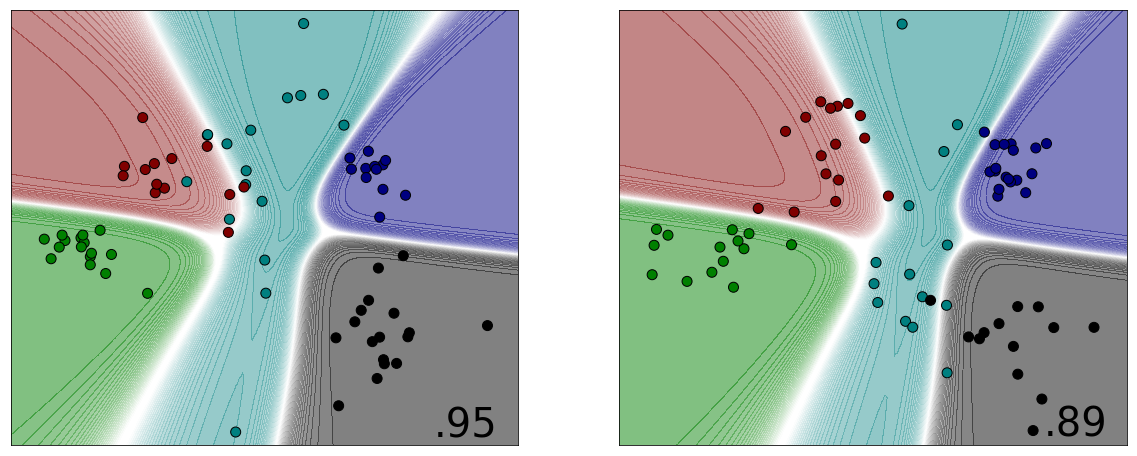

119
46176/46176 [==============================] - 1s     


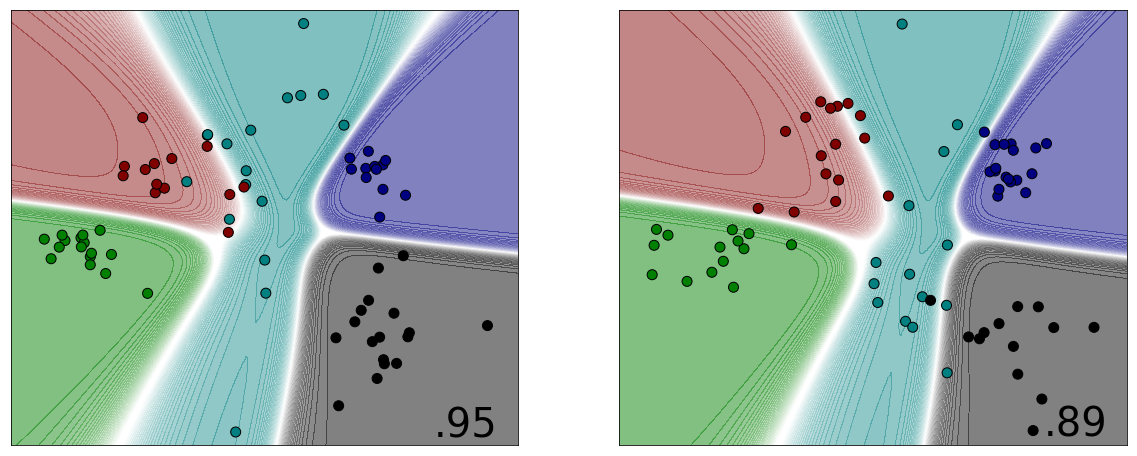

147
45056/46176 [============================>.] - ETA: 0s

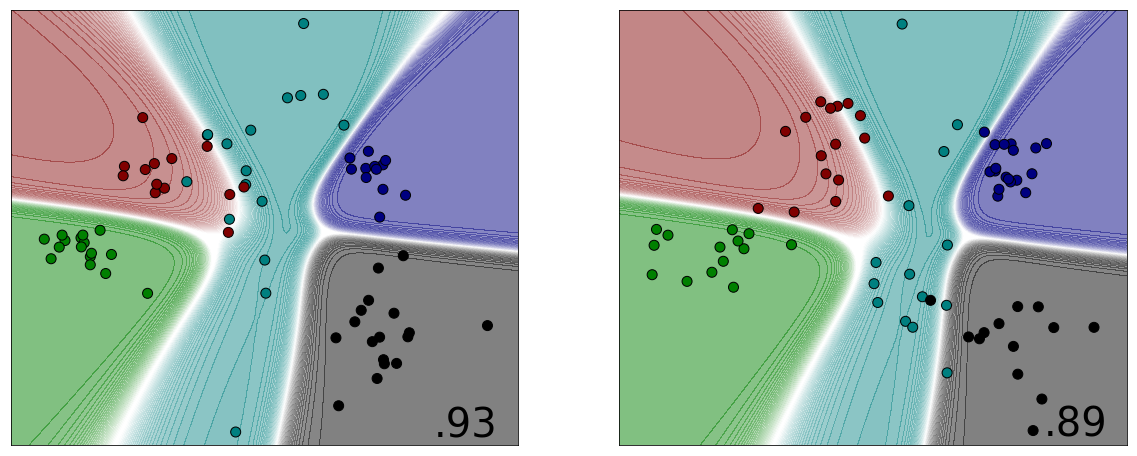

183
44544/46176 [===========================>..] - ETA: 0s

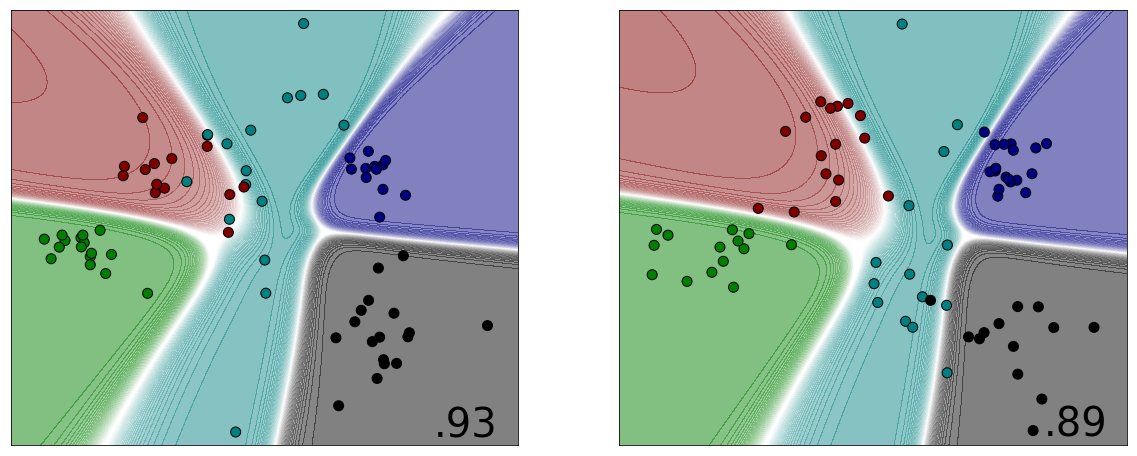

226
44096/46176 [===========================>..] - ETA: 0s

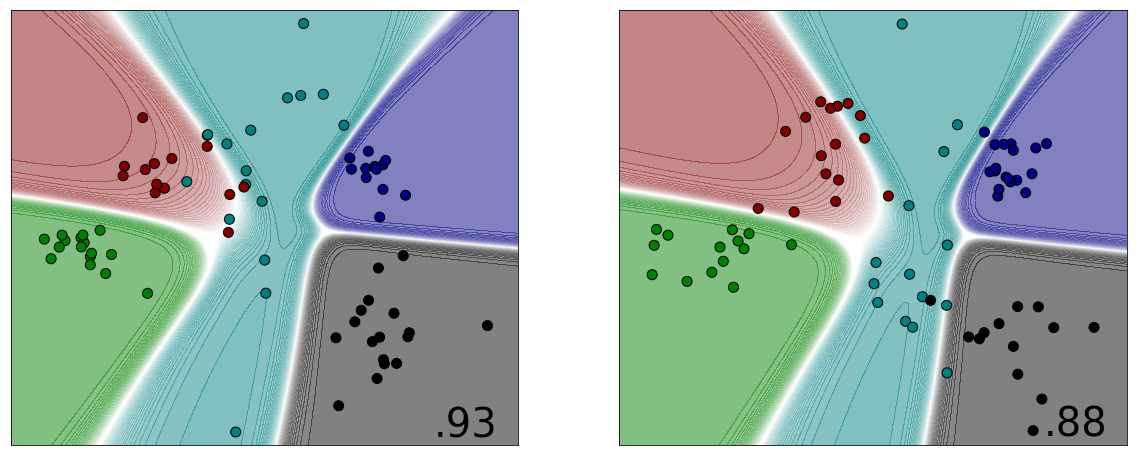

279
45856/46176 [============================>.] - ETA: 0s

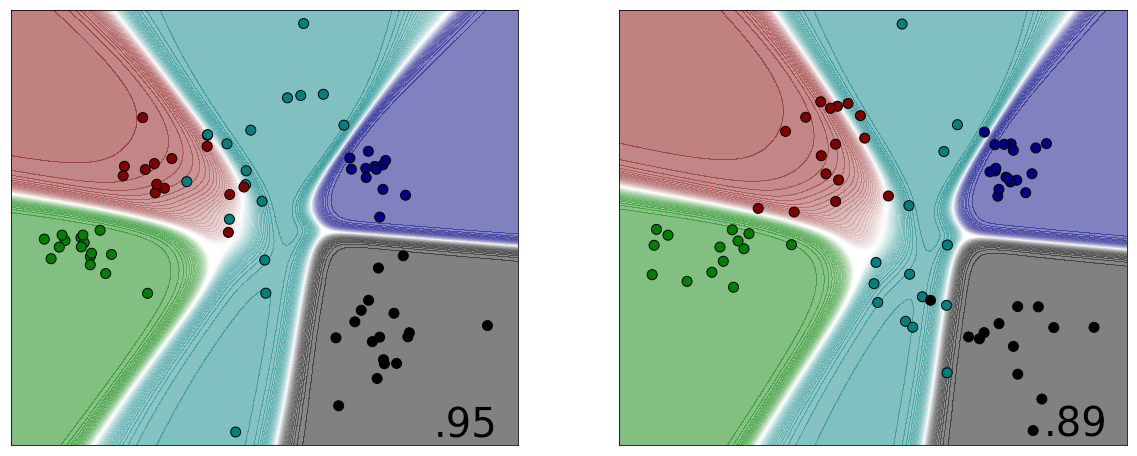

346
46048/46176 [============================>.] - ETA: 0s

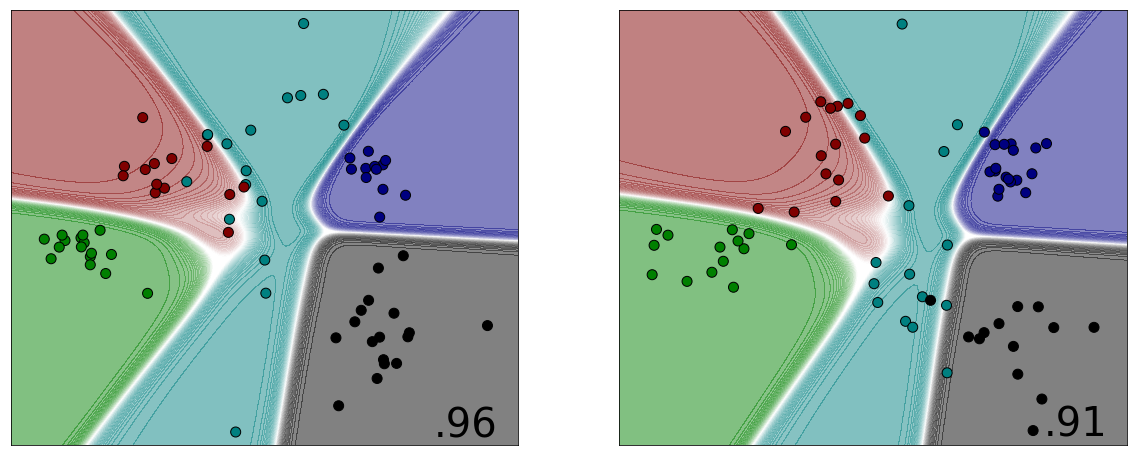

427
43584/46176 [===========================>..] - ETA: 0s

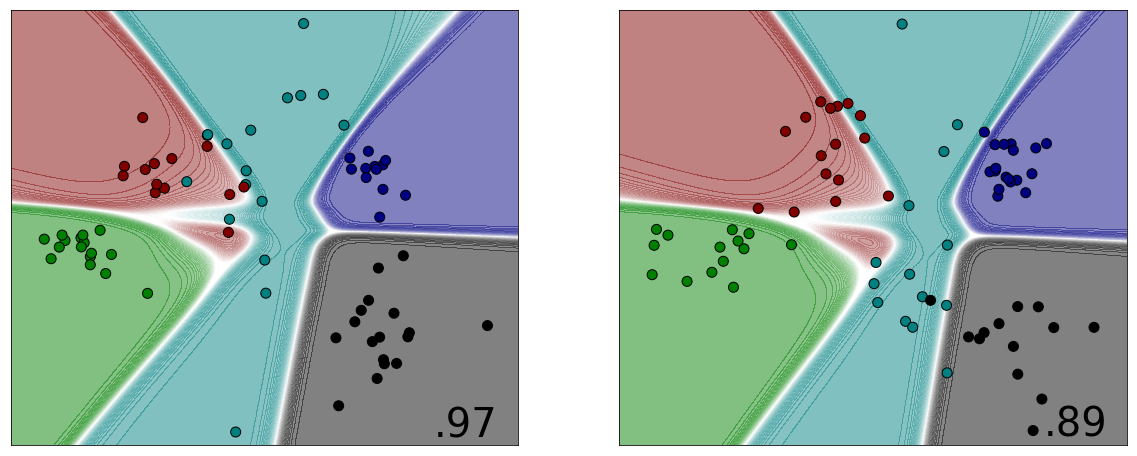

529
44384/46176 [===========================>..] - ETA: 0s

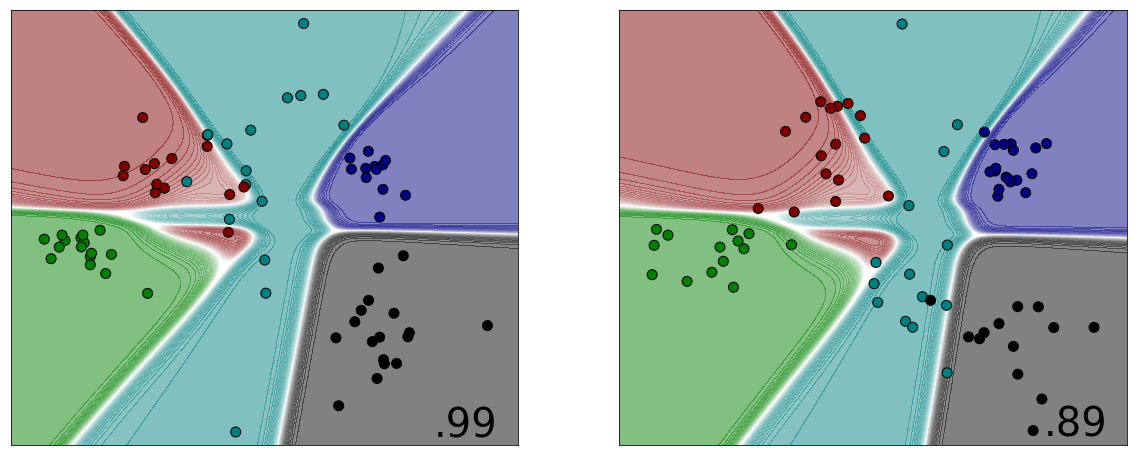

654
45280/46176 [============================>.] - ETA: 0s

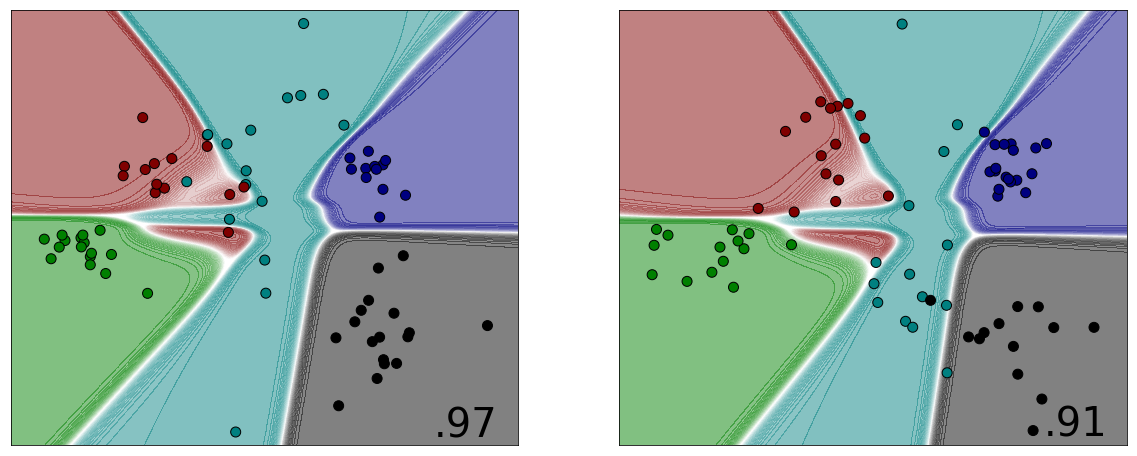

808
45984/46176 [============================>.] - ETA: 0s

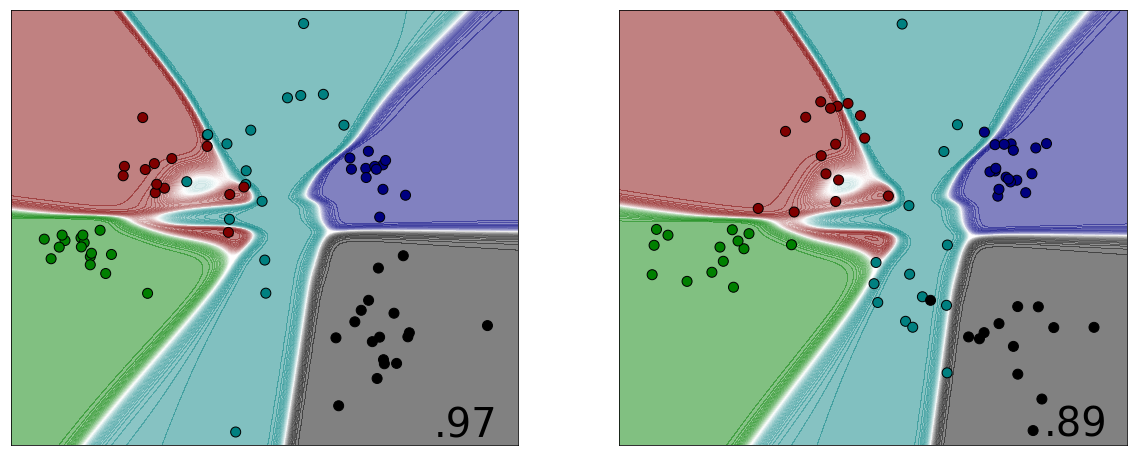

999
43936/46176 [===========================>..] - ETA: 0s

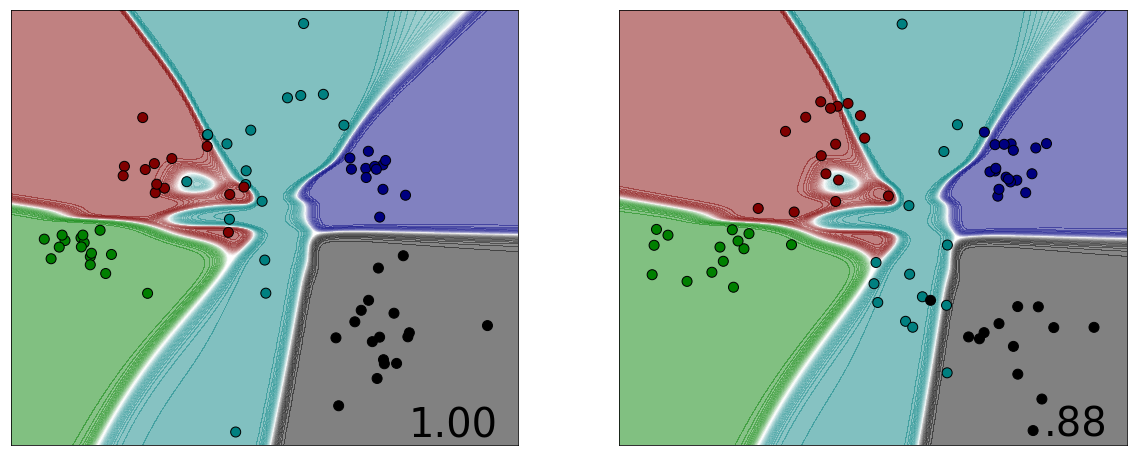

In [150]:
start = 0
log_space = gen_log_space(N, 30)
for index, i in enumerate(log_space[start:]):
    print(i)
    file = files[i]
    epoch = int(file.split('-')[-2].split('weights.')[-1])
    model.load_weights(file)
    acc = model.evaluate(X_train, y_train_cat)[1]
    val_acc = model.evaluate(X_test, y_test_cat)[1]
    #print(epoch, acc, val_acc)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
    score_train = model.evaluate(X_train, y_train_cat)
    score_test = model.evaluate(X_test, y_test_cat)
    Z_aux, Z = plot_boundaries_keras(X_train, y_train, score_train[1], model.predict_proba, h =.05, ax=ax1)
    Z_aux, Z = plot_boundaries_keras(X_test, y_test, score_test[1], model.predict_proba, h =.05, ax=ax2)
    plt.savefig(directory_images+'%04.d'%index)
    plt.show()